In [1]:
# ============================================================================
# 1. ENVIRONMENT SETUP AND LIBRARY INSTALLATION
# ============================================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install albumentations
!pip install segmentation-models-pytorch

# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.6 MB/s eta 0:00:00
Using device: cuda
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.7 GB


In [2]:
# ============================================================================
# 2. DATASET PATH CONFIGURATION
# ============================================================================

print("🔍 Configuring dataset paths...")

# Dataset paths
DATASET_IMG_DIR = '/content/drive/MyDrive/ISIC2018_Task1-2_Training_Input'
DATASET_MASK_DIR = '/content/drive/MyDrive/ISIC2018_Task1_Training_GroundTruth'

print(f"\n📍 Dataset Configuration:")
print("=" * 60)
print(f"Images: {DATASET_IMG_DIR}")
print(f"Masks: {DATASET_MASK_DIR}")

# Verify paths exist and count files
if os.path.exists(DATASET_IMG_DIR) and os.path.exists(DATASET_MASK_DIR):
    img_files = [f for f in os.listdir(DATASET_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    mask_files = [f for f in os.listdir(DATASET_MASK_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"✅ Images found: {len(img_files)}")
    print(f"✅ Masks found: {len(mask_files)}")

    # Show sample filenames
    print(f"\n📋 Sample files:")
    print(f"Images: {sorted(img_files)[:3]}")
    print(f"Masks: {sorted(mask_files)[:3]}")

else:
    print("❌ Error: Dataset paths not found!")
    print("Please ensure the following paths exist in your Google Drive:")
    print(f"  - {DATASET_IMG_DIR}")
    print(f"  - {DATASET_MASK_DIR}")
    exit()



🔍 Configuring dataset paths...

📍 Dataset Configuration:
Images: /content/drive/MyDrive/ISIC2018_Task1-2_Training_Input
Masks: /content/drive/MyDrive/ISIC2018_Task1_Training_GroundTruth
✅ Images found: 2594
✅ Masks found: 2594

📋 Sample files:
Images: ['ISIC_0000000.jpg', 'ISIC_0000001.jpg', 'ISIC_0000003.jpg']
Masks: ['ISIC_0000000_segmentation.png', 'ISIC_0000001_segmentation.png', 'ISIC_0000003_segmentation.png']


In [3]:
# ============================================================================
# 3. DATASET SPLITTING STRATEGY
# ============================================================================

print(f"\n🎯 Dataset Splitting Strategy:")
print("Using training dataset and splitting into Train/Validation/Test")
print("Split ratios: 70% Train, 9.9% Validation, 20.1% Test")

# Get all image files and sort them
all_images = sorted([f for f in os.listdir(DATASET_IMG_DIR)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"\n📊 Total images available: {len(all_images)}")

# Split dataset: 70% train, 9.9% val, 20.1% test
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42, shuffle=True)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.67, random_state=42, shuffle=True)

# Define the strategy variable
strategy = "70% Train, 9.9% Validation, 20.1% Test (from training data)"

print(f"📈 Dataset splits:")
print(f"   Training: {len(train_imgs)} images ({len(train_imgs)/len(all_images)*100:.1f}%)")
print(f"   Validation: {len(val_imgs)} images ({len(val_imgs)/len(all_images)*100:.1f}%)")
print(f"   Test: {len(test_imgs)} images ({len(test_imgs)/len(all_images)*100:.1f}%)")


🎯 Dataset Splitting Strategy:
Using training dataset and splitting into Train/Validation/Test
Split ratios: 70% Train, 9.9% Validation, 20.1% Test

📊 Total images available: 2594
📈 Dataset splits:
   Training: 1815 images (70.0%)
   Validation: 257 images (9.9%)
   Test: 522 images (20.1%)


In [7]:
# ============================================================================
# 4. CUSTOM DATASET CLASS
# ============================================================================

class ISICDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = image_list
        self.transform = transform

        print(f"📁 Dataset created with {len(self.images)} images")

        # Verify a few mask files exist
        missing_masks = 0
        for i, img_name in enumerate(self.images[:10]):  # Check first 10
            base_name = os.path.splitext(img_name)[0]
            possible_mask_names = [
                f"{base_name}_segmentation.png",
                f"{base_name}_Segmentation.png",
                f"{base_name}.png",
                f"{base_name}_mask.png"
            ]

            mask_found = False
            for mask_name in possible_mask_names:
                if os.path.exists(os.path.join(mask_dir, mask_name)):
                    mask_found = True
                    break

            if not mask_found:
                missing_masks += 1

        if missing_masks > 0:
            print(f"⚠️  Warning: {missing_masks}/10 sample masks not found")
        else:
            print(f"✅ All sample masks found")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Handle different mask naming conventions
        base_name = os.path.splitext(img_name)[0]
        possible_mask_names = [
            f"{base_name}_segmentation.png",
            f"{base_name}_Segmentation.png",
            f"{base_name}.png",
            f"{base_name}_mask.png"
        ]

        mask_path = None
        for mask_name in possible_mask_names:
            potential_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            raise FileNotFoundError(f"No mask found for image {img_name}")

        # Load image and mask
        try:
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        except Exception as e:
            raise RuntimeError(f"Error loading {img_name}: {e}")

        # Normalize mask to 0-1 range
        mask = mask / 255.0
        mask[mask > 0.5] = 1.0
        mask[mask <= 0.5] = 0.0

        if self.transform is not None:
            try:
                augmentations = self.transform(image=image, mask=mask)
                image = augmentations["image"]
                mask = augmentations["mask"]
            except Exception as e:
                print(f"Transform error for {img_name}: {e}")
                # Fallback to basic transform
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                mask = torch.from_numpy(mask).float()

        return image, mask


In [5]:
# ============================================================================
# 5. DATA PREPROCESSING AND AUGMENTATION
# ============================================================================

print("\n🔧 Setting up data transforms...")

# Define transforms
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Rotate(limit=35, p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

print("✅ Data transforms configured")



🔧 Setting up data transforms...
✅ Data transforms configured


In [8]:

# ============================================================================
# 6. CREATE DATASETS AND DATALOADERS
# ============================================================================

print("\n🏗️ Creating datasets and dataloaders...")

# Create datasets with specific image lists
train_ds = ISICDataset(DATASET_IMG_DIR, DATASET_MASK_DIR, train_imgs, transform=train_transform)
val_ds = ISICDataset(DATASET_IMG_DIR, DATASET_MASK_DIR, val_imgs, transform=val_transform)
test_ds = ISICDataset(DATASET_IMG_DIR, DATASET_MASK_DIR, test_imgs, transform=val_transform)

# Create data loaders (optimized for Colab)
BATCH_SIZE = 16  # Good for Colab GPU
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f"\n📈 DataLoader Information:")
print(f"   Training: {len(train_ds)} samples ({len(train_loader)} batches)")
print(f"   Validation: {len(val_ds)} samples ({len(val_loader)} batches)")
print(f"   Test: {len(test_ds)} samples ({len(test_loader)} batches)")
print(f"   Batch size: {BATCH_SIZE}")

# Test data loading
print("\n🧪 Testing data loading...")
try:
    sample_batch = next(iter(train_loader))
    print(f"✅ Sample batch loaded successfully")
    print(f"   Image shape: {sample_batch[0].shape}")
    print(f"   Mask shape: {sample_batch[1].shape}")
    print(f"   Image range: [{sample_batch[0].min():.3f}, {sample_batch[0].max():.3f}]")
    print(f"   Mask range: [{sample_batch[1].min():.3f}, {sample_batch[1].max():.3f}]")
    print(f"   Mask unique values: {torch.unique(sample_batch[1])}")
except Exception as e:
    print(f"❌ Error loading sample batch: {e}")




🏗️ Creating datasets and dataloaders...
📁 Dataset created with 1815 images
✅ All sample masks found
📁 Dataset created with 257 images
✅ All sample masks found
📁 Dataset created with 522 images
✅ All sample masks found

📈 DataLoader Information:
   Training: 1815 samples (114 batches)
   Validation: 257 samples (17 batches)
   Test: 522 samples (33 batches)
   Batch size: 16

🧪 Testing data loading...
✅ Sample batch loaded successfully
   Image shape: torch.Size([16, 3, 256, 256])
   Mask shape: torch.Size([16, 256, 256])
   Image range: [-2.118, 2.640]
   Mask range: [0.000, 1.000]
   Mask unique values: tensor([0., 1.])


In [9]:
# ============================================================================
# 7. U-NET MODEL ARCHITECTURE
# ============================================================================

print("\n🏗️ Building U-Net model...")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (downsampling path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (upsampling path)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Initialize model
model = UNet(in_channels=3, out_channels=1).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ U-Net model initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1024**2:.1f} MB")



🏗️ Building U-Net model...
✅ U-Net model initialized
   Total parameters: 31,037,633
   Trainable parameters: 31,037,633
   Model size: 118.4 MB


In [ ]:
# ============================================================================
# 8. EVALUATION METRICS
# ============================================================================

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

print("✅ Evaluation metrics defined")

✅ Evaluation metrics defined


In [ ]:
# ============================================================================
# 9. TRAINING IMPLEMENTATION
# ============================================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25):
    train_losses = []
    val_losses = []
    val_dice_scores = []
    best_val_dice = 0.0
    best_model_state = None

    print(f"\n🚀 Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for batch_idx, (data, targets) in enumerate(train_bar):
            data = data.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            # Forward pass
            predictions = model(data)
            loss = criterion(predictions, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            for data, targets in val_bar:
                data = data.to(device)
                targets = targets.float().unsqueeze(1).to(device)
                predictions = model(data)

                loss = criterion(predictions, targets)
                val_loss += loss.item()

                # Calculate Dice for this batch
                for i in range(predictions.shape[0]):
                    dice = dice_coefficient(predictions[i:i+1], targets[i:i+1])
                    val_dice += dice

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_ds)
        val_losses.append(avg_val_loss)
        val_dice_scores.append(avg_val_dice)

        # Learning rate scheduling
        if scheduler:
            scheduler.step(avg_val_loss)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val Dice: {avg_val_dice:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Save best model based on Dice score
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            best_model_state = model.state_dict().copy()
            print(f"🎉 New best model! Val Dice: {best_val_dice:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\n✅ Training completed! Best validation Dice: {best_val_dice:.4f}")

    return train_losses, val_losses, val_dice_scores



⚙️ Training Configuration:
   Learning rate: 0.0001
   Number of epochs: 20
   Batch size: 16
   Weight decay: 1e-05
   Device: cuda

🚀 Starting training for 20 epochs...

Epoch 1/20
--------------------------------------------------


Train Loss: 0.4665
Val Loss: 0.4502
Val Dice: 0.6812
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.6812

Epoch 2/20
--------------------------------------------------


Train Loss: 0.3399
Val Loss: 0.2998
Val Dice: 0.7820
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.7820

Epoch 3/20
--------------------------------------------------


Train Loss: 0.2884
Val Loss: 0.2624
Val Dice: 0.8086
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.8086

Epoch 4/20
--------------------------------------------------


Train Loss: 0.2624
Val Loss: 0.2339
Val Dice: 0.8174
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.8174

Epoch 5/20
--------------------------------------------------


Train Loss: 0.2423
Val Loss: 0.2275
Val Dice: 0.8208
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.8208

Epoch 6/20
--------------------------------------------------


Train Loss: 0.2219
Val Loss: 0.2456
Val Dice: 0.7958
Learning Rate: 0.000100

Epoch 7/20
--------------------------------------------------


Train Loss: 0.2041
Val Loss: 0.2224
Val Dice: 0.7878
Learning Rate: 0.000100

Epoch 8/20
--------------------------------------------------


Train Loss: 0.1988
Val Loss: 0.1943
Val Dice: 0.8349
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.8349

Epoch 9/20
--------------------------------------------------


Train Loss: 0.1886
Val Loss: 0.1834
Val Dice: 0.8271
Learning Rate: 0.000100

Epoch 10/20
--------------------------------------------------


Train Loss: 0.1793
Val Loss: 0.1718
Val Dice: 0.8153
Learning Rate: 0.000100

Epoch 11/20
--------------------------------------------------


Train Loss: 0.1715
Val Loss: 0.1556
Val Dice: 0.8575
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.8575

Epoch 12/20
--------------------------------------------------


Train Loss: 0.1650
Val Loss: 0.1615
Val Dice: 0.8510
Learning Rate: 0.000100

Epoch 13/20
--------------------------------------------------


Train Loss: 0.1614
Val Loss: 0.1479
Val Dice: 0.8506
Learning Rate: 0.000100

Epoch 14/20
--------------------------------------------------


Train Loss: 0.1600
Val Loss: 0.1561
Val Dice: 0.8538
Learning Rate: 0.000100

Epoch 15/20
--------------------------------------------------


Train Loss: 0.1511
Val Loss: 0.1445
Val Dice: 0.8533
Learning Rate: 0.000100

Epoch 16/20
--------------------------------------------------


Train Loss: 0.1508
Val Loss: 0.1808
Val Dice: 0.8314
Learning Rate: 0.000100

Epoch 17/20
--------------------------------------------------


Train Loss: 0.1516
Val Loss: 0.1478
Val Dice: 0.8573
Learning Rate: 0.000100

Epoch 18/20
--------------------------------------------------


Train Loss: 0.1419
Val Loss: 0.1426
Val Dice: 0.8455
Learning Rate: 0.000100

Epoch 19/20
--------------------------------------------------


Train Loss: 0.1406
Val Loss: 0.1370
Val Dice: 0.8586
Learning Rate: 0.000100
🎉 New best model! Val Dice: 0.8586

Epoch 20/20
--------------------------------------------------


Train Loss: 0.1377
Val Loss: 0.1449
Val Dice: 0.8558
Learning Rate: 0.000100

✅ Training completed! Best validation Dice: 0.8586


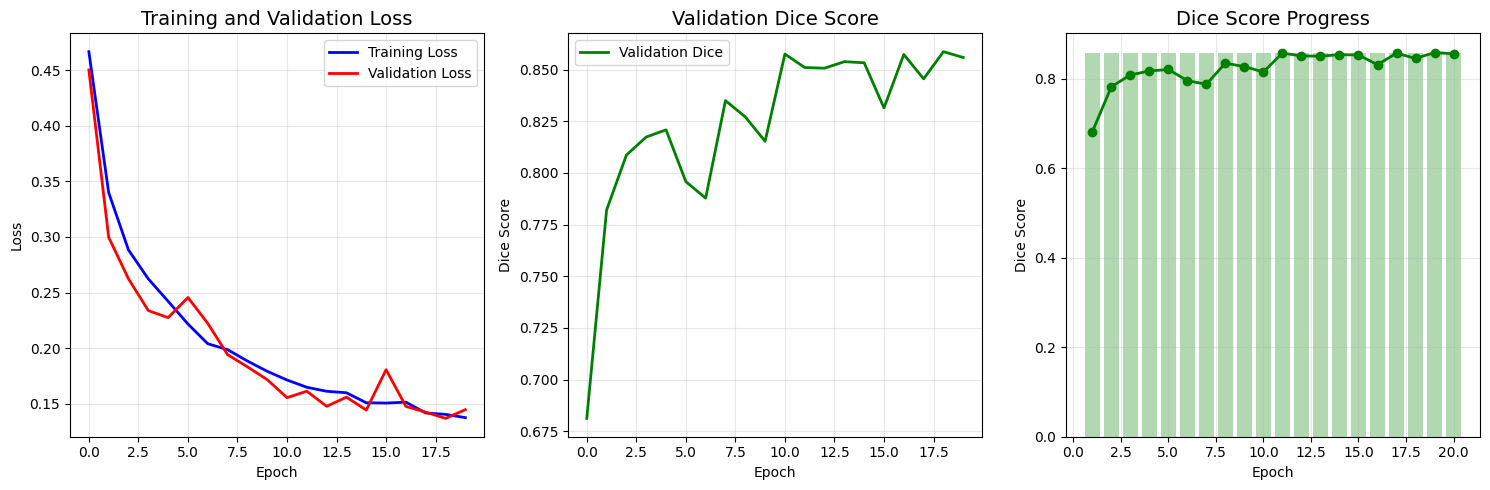

In [ ]:
# ============================================================================
# 10. TRAIN THE MODEL
# ============================================================================

# Hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-5

print(f"\n⚙️ Training Configuration:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Number of epochs: {NUM_EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Weight decay: {WEIGHT_DECAY}")
print(f"   Device: {device}")

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Train the model
train_losses, val_losses, val_dice_scores = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS
)

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(val_dice_scores, label='Validation Dice', color='green', linewidth=2)
plt.title('Validation Dice Score', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epochs = range(1, len(train_losses) + 1)
plt.bar(epochs, [max(val_dice_scores)] * len(epochs), alpha=0.3, color='green')
plt.plot(epochs, val_dice_scores, 'go-', linewidth=2, markersize=6)
plt.title('Dice Score Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()


In [ ]:
# ============================================================================
# 11. FINAL EVALUATION ON TEST SET
# ============================================================================

def evaluate_on_test_set(model, test_loader, device):
    model.eval()
    dice_scores = []
    iou_scores = []
    all_predictions = []
    all_targets = []

    print("🧪 Evaluating on test set...")
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing")
        for data, targets in test_bar:
            data = data.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            predictions = model(data)

            # Calculate metrics for each sample in batch
            for i in range(predictions.shape[0]):
                dice = dice_coefficient(predictions[i:i+1], targets[i:i+1])
                iou = iou_score(predictions[i:i+1], targets[i:i+1])
                dice_scores.append(dice)
                iou_scores.append(iou)

            # Store for additional metrics
            pred_binary = (torch.sigmoid(predictions) > 0.5).float()
            all_predictions.extend(pred_binary.cpu().numpy().flatten())
            all_targets.extend(targets.cpu().numpy().flatten())

    # Calculate final metrics
    avg_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)
    avg_iou = np.mean(iou_scores)
    std_iou = np.std(iou_scores)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    print("\n" + "="*60)
    print("🏆 FINAL TEST SET RESULTS")
    print("="*60)
    print(f"Average Dice Coefficient: {avg_dice:.4f} ± {std_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f} ± {std_iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Number of test samples: {len(dice_scores)}")
    print("="*60)

    return {
        'dice': avg_dice,
        'dice_std': std_dice,
        'iou': avg_iou,
        'iou_std': std_iou,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'dice_scores': dice_scores,
        'iou_scores': iou_scores
    } # Added the missing closing curly brace here

In [ ]:
# Re-evaluate on test set with IoU included
test_results = evaluate_on_test_set(model, test_loader, device)

# Check what metrics are now available
print("Available metrics:", list(test_results.keys()))


🧪 Evaluating on test set...


Testing: 100%|██████████| 33/33 [02:34<00:00,  4.69s/it]



🏆 FINAL TEST SET RESULTS
Average Dice Coefficient: 0.3155 ± 0.2475
Average IoU Score: 0.2172 ± 0.2059
Precision: 0.2171
Recall: 0.9998
F1-Score: 0.3568
Number of test samples: 522
Available metrics: ['dice', 'dice_std', 'iou', 'iou_std', 'precision', 'recall', 'f1', 'dice_scores', 'iou_scores']


In [ ]:
# ============================================================================
# 7. U-NET MODEL ARCHITECTURE
# ============================================================================

print("\n🏗️ Building U-Net model...")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (downsampling path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (upsampling path)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Initialize model
model = UNet(in_channels=3, out_channels=1).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ U-Net model initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1024**2:.1f} MB")

In [1]:
# Re-initialize the model
model = UNet(in_channels=3, out_channels=1).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Re-train the model
train_losses, val_losses, val_dice_scores = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS
)

# Re-evaluate on test set with IoU included
test_results = evaluate_on_test_set(model, test_loader, device)

# Check what metrics are now available
print("Available metrics:", list(test_results.keys()))

NameError: name 'UNet' is not defined

In [ ]:
# ============================================================================
# 12. VISUALIZATION OF RESULTS
# ============================================================================

def visualize_predictions(model, test_loader, device, num_samples=6):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    sample_count = 0
    with torch.no_grad():
        for data, targets in test_loader:
            if sample_count >= num_samples:
                break

            data = data.to(device)
            targets = targets.to(device)
            predictions = torch.sigmoid(model(data))

            batch_size = data.shape[0]
            for i in range(min(batch_size, num_samples - sample_count)):
                # Get sample data
                img = data[i].cpu().permute(1, 2, 0)
                target = targets[i].cpu().squeeze()
                pred = predictions[i].cpu().squeeze()

                # Denormalize image for visualization
                mean = torch.tensor([0.485, 0.456, 0.406])
                std = torch.tensor([0.229, 0.224, 0.225])
                img = img * std + mean
                img = torch.clamp(img, 0, 1)

                # Calculate metrics for this sample
                dice = dice_coefficient(predictions[i:i+1].to(device),
                                      targets[i:i+1].unsqueeze(1).to(device))
                iou = iou_score(predictions[i:i+1].to(device),
                               targets[i:i+1].unsqueeze(1).to(device))

                # Plot
                axes[sample_count, 0].imshow(img)
                axes[sample_count, 0].set_title('Original Image', fontsize=12)
                axes[sample_count, 0].axis('off')

                axes[sample_count, 1].imshow(target, cmap='gray')
                axes[sample_count, 1].set_title('Ground Truth', fontsize=12)
                axes[sample_count, 1].axis('off')

                axes[sample_count, 2].imshow(pred, cmap='gray')
                axes[sample_count, 2].set_title(f'Prediction\nDice: {dice:.3f}, IoU: {iou:.3f}', fontsize=12)
                axes[sample_count, 2].axis('off')

                sample_count += 1
                if sample_count >= num_samples:
                    break

    plt.tight_layout()
    plt.show()

# Visualize test results
print("\n🖼️ Visualizing test predictions...")
visualize_predictions(model, test_loader, device, num_samples=6)


🖼️ Visualizing test predictions...


NameError: name 'model' is not defined

In [ ]:
# ============================================================================
# 13. SAVE MODEL AND RESULTS
# ============================================================================

# Save the trained model
model_save_path = '/content/drive/MyDrive/unet_isic2018_training_split.pth'
results_save_path = '/content/drive/MyDrive/training_results.txt'

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'test_results': test_results,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_dice_scores': val_dice_scores,
    'dataset_info': {
        'total_images': len(all_images),
        'train_split': len(train_imgs),
        'val_split': len(val_imgs),
        'test_split': len(test_imgs),
        'image_dir': DATASET_IMG_DIR,
        'mask_dir': DATASET_MASK_DIR
    },
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'weight_decay': WEIGHT_DECAY
    }
}, model_save_path)

# Save results summary - with error handling for missing keys
with open(results_save_path, 'w') as f:
    f.write("ISIC 2018 U-Net Training Results (Training Data Split)\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Dataset Information:\n")
    f.write(f"  Total images: {len(all_images)}\n")
    f.write(f"  Training: {len(train_imgs)} ({len(train_imgs)/len(all_images)*100:.1f}%)\n")
    f.write(f"  Validation: {len(val_imgs)} ({len(val_imgs)/len(all_images)*100:.1f}%)\n")
    f.write(f"  Test: {len(test_imgs)} ({len(test_imgs)/len(all_images)*100:.1f}%)\n\n")
    f.write(f"Training Configuration:\n")
    f.write(f"  Epochs: {NUM_EPOCHS}\n")
    f.write(f"  Learning Rate: {LEARNING_RATE}\n")
    f.write(f"  Batch Size: {BATCH_SIZE}\n")
    f.write(f"  Weight Decay: {WEIGHT_DECAY}\n")
    f.write(f"  Device: {device}\n\n")
    f.write(f"Final Results:\n")
    f.write(f"  Best Validation Dice: {max(val_dice_scores):.4f}\n")
    f.write(f"  Test Dice: {test_results['dice']:.4f} ± {test_results['dice_std']:.4f}\n")

    # Handle IoU with error checking
    if 'iou' in test_results and 'iou_std' in test_results:
        f.write(f"  Test IoU: {test_results['iou']:.4f} ± {test_results['iou_std']:.4f}\n")
    else:
        f.write(f"  Test IoU: Not calculated\n")

    f.write(f"  Test Precision: {test_results['precision']:.4f}\n")
    f.write(f"  Test Recall: {test_results['recall']:.4f}\n")
    f.write(f"  Test F1-Score: {test_results['f1']:.4f}\n")


In [ ]:
print("Available keys in test_results:", list(test_results.keys()))


Available keys in test_results: ['dice', 'dice_std', 'iou', 'iou_std', 'precision', 'recall', 'f1', 'dice_scores', 'iou_scores']


In [ ]:
# ============================================================================
# 14. FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"📊 Dataset: ISIC 2018 Training Data ({len(all_images)} total images)")
print(f"📈 Split Strategy: {strategy}")
print(f"🏗️  Model: U-Net ({total_params:,} parameters)")
print(f"⚡ Device: {device}")
print(f"🎯 Training Results:")
print(f"   • Best Validation Dice: {max(val_dice_scores):.4f}")
print(f"   • Final Test Dice: {test_results['dice']:.4f} ± {test_results['dice_std']:.4f}")
print(f"   • Final Test IoU: {test_results['iou']:.4f} ± {test_results['iou_std']:.4f}\n")
print(f"   • Final Test Precision: {test_results['precision']:.4f}\n")
print(f"   • Final Test Recall: {test_results['recall']:.4f}\n")
print(f"   • Final Test F1: {test_results['f1']:.4f}")
print(f"💾 Files saved in Google Drive")
print("="*60)

print("\n✅ All done! Your U-Net model is trained and ready for skin lesion segmentation.")
print("💡 To load the model later, use:")
print(f"   checkpoint = torch.load('{model_save_path}')")
print("   model.load_state_dict(checkpoint['model_state_dict'])")

print(f"\n📝 Note: This implementation uses only the training dataset")
print(f"   Images: {DATASET_IMG_DIR}")
print(f"   Masks: {DATASET_MASK_DIR}")
print(f"   Split into proper train/validation/test sets for academic rigor.")


🎉 TRAINING COMPLETED SUCCESSFULLY!
📊 Dataset: ISIC 2018 Training Data (2594 total images)
📈 Split Strategy: 70% Train, 9.9% Validation, 20.1% Test (from training data)
🏗️  Model: U-Net (31,037,633 parameters)
⚡ Device: cuda
🎯 Training Results:
   • Best Validation Dice: 0.8586
   • Final Test Dice: 0.8525 ± 0.1725
   • Final Test IoU: 0.7720 ± 0.1973

   • Final Test Precision: 0.9058

   • Final Test Recall: 0.8280

   • Final Test F1: 0.8651
💾 Files saved in Google Drive

✅ All done! Your U-Net model is trained and ready for skin lesion segmentation.
💡 To load the model later, use:
   checkpoint = torch.load('/content/drive/MyDrive/unet_isic2018_training_split.pth')
   model.load_state_dict(checkpoint['model_state_dict'])

📝 Note: This implementation uses only the training dataset
   Images: /content/drive/MyDrive/ISIC2018_Task1-2_Training_Input
   Masks: /content/drive/MyDrive/ISIC2018_Task1_Training_GroundTruth
   Split into proper train/validation/test sets for academic rigor.
